# Stroke Risk Prediction Model: Johns Hopkins Hospital

## Introduction

### Background

In this project I will explore dataset designed to identify stroke risk in patients. Stroke is a major global health concern, ranking as the second leading cause of death worldwide. It is also a leading cause of disability. Annually, millions experience strokes, and a significant number of these result in death. After data exploration and analysis, I will build, train and deploy a model which could predict whether patients is likely to have stroke or not, based on parameters like age, gender, lifestyle choices, bmi and so on. 

### Problem

It’s hard to spot which patients are at high risk of stroke, making it tough to catch it early and prevent it.

### Goal

To build a model that helps doctors spot patients at higher risk of stroke early so they can take action and help prevent deaths.

### Hypotheses

5 hypotheses I want to explore:

1. Older age increases likelyhood of stroke.
- **H₀:** Age is not associated with stroke risk.
- **H₁:** Increasing age is associated with higher stroke risk

2. Males are more likely to have a stroke than females.
- **H₀:** Gender has no effect on stroke risk.
- **H₁:** Male patients have a higher probability of experiencing a stroke than female patients.

3. Obesity increases risk of a stroke.
- **H₀:** BMI is not associated with stroke risk.
- **H₁:** Higher BMI is associated with an increased likelihood of stroke.

4. Having a hypertension increases chances of having a stroke
- **H₀:** Hypertension is not associated with stroke risk.
- **H₁:** Patients with hypertension have higher odds of experiencing a stroke.

### Scope

The analysis scope includes :

- Data cleaning and preparation.
- Descriptive analysis of patient demographics and health indicators.
- Formulation and testing of clear, interpretable hypotheses about risk factors.
- Development of various  models to predict stroke likelihood.
- Interpretation of results to inform potential early intervention strategies.

The project is limited to the variables available in the provided dataset and does not incorporate external medical records or real-time clinical data. The findings are intended for educational and exploratory purposes and do not replace professional medical advice.

### Evaluation Metrics

**Main Evaluation Metric:** Macro F1 Score. Balances precision and recall across classes to ensure fair assesment of performance on both stroke and non-strokes case in an imbalanced dataset.

**Secondary Evaluation Metrics:**
- Recall. Measures the ability to correctly indentify true stroke cases.
- Precision. Assesses how many predicted stroke cases are actually correct.
- ROC-AUC. It evaluates the model's ability to distinquish betweeen strokes and non-stroke cases.
- Confusion Matrix. Provides detailed breakdown of correct and incorrect predictions.

## Data Overview and Splitting

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.lines as mlines
from phik import phik_matrix

### Data Source and Loading the Data

Data source is Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

Loading the data and making a copy of it:

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df = data.copy()

### Feature Definitions

- **id**: Unique patient identifier (integer).  
- **gender**: Patient gender (Male, Female, or Other).  
- **age**: Patient age in years (float).  
- **hypertension**: Binary indicator of hypertension (0 = No, 1 = Yes).  
- **heart_disease**: Binary indicator of heart disease (0 = No, 1 = Yes).  
- **ever_married**: Marital status (Yes/No).  
- **work_type**: Type of employment (e.g., Private, Self-employed, Govt_job, Children, Never_worked).  
- **Residence_type**: Urban or Rural residence.  
- **avg_glucose_level**: Average blood glucose level (float).  
- **bmi**: Body Mass Index (float).
- **smoking_status**: Smoking status (Never smoked, Formerly smoked, Smokes, Unknown).  
- **stroke**: Target variable indicating stroke occurrence (0 = No, 1 = Yes).

### General Data Overview

Checking the columns:

In [4]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

The ID column is unnecessary and provides no value, I can drop it:

In [5]:
df.drop(columns=["id"], inplace=True)

Checking the shape of the dataset:

In [6]:
df.shape

(5110, 11)

Previewing the tail of the data set:

In [7]:
df.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


**Interpretation:** Sample data shows varied patient details with some missing BMI values and cathegorical features needing encoding.

In [8]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**Interpretation:** 

- Numerical features show wide ranges: age spans from infancy to 82, average glucose levels and BMI have high variability.

- Stroke prevalence is low, about 5%, suggesting that there's class imbalance.

- Again confirmed that BMI has missing values.

### Splitting the Data

I will split data early to avoid data leakage.

Defining features and target:

In [9]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

Splitting into training and testing sets:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Confirming shapes:

In [11]:
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (3577, 10)
Testing set size: (1533, 10)


**Interpretation:** I splitted data to 70/30 instead of 80/20, to ensure sufficient stroke cases in the test set for evaluation, adressing the class imbalance, dataset size and possibly improving the reliability of performance metrics.

## Data Cleaning (Training Data)

Checking for duplicates:

In [12]:
df.duplicated().sum()

np.int64(0)

Confirming missing values:

In [13]:
df.isnull().sum().sum()

np.int64(201)

In [14]:
df[df["bmi"].isnull()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


**Interpretation:** Exploration shows BMI is more often missing in older, higher-risk patients. To reduce bias, median imputation within age groups will be applied instead of single global median.

Binning age into groups:

In [15]:
age_bins = [0, 1, 4, 12, 19, 39, 59, 64, 120]
age_labels = [
    "Infant",
    "Toddler",
    "Child",
    "Teen",
    "Young Adult",
    "Middle-Aged Adult",
    "Senior Adult",
    "Elderly",
]

Creating age_group column:

In [16]:
df["age_group"] = pd.cut(
    df["age"], bins=age_bins, labels=age_labels, right=True, include_lowest=True
)

Imputing BMI withing age groups:

In [17]:
df["bmi"] = df.groupby("age_group", observed=False)["bmi"].transform(
    lambda x: x.fillna(x.median())
)

Confirming the change:

In [18]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group'],
      dtype='object')

Confirming there no missing values left:

In [19]:
df.isnull().sum().sum()

np.int64(0)

**Interpretation:** 

- Age was binned into clinically meaningful groups and new column of age group was created. 

- Missing BMI values were impurted using the median BMI withing each age group to reduce bias and reflect age-specific health profiles.

Checking distribution of genders:

In [20]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Since there is only 1 record of Other gender, I will delete it since it gives me not enough data to learn patterns:

In [21]:
df = df[df["gender"].isin(["Male", "Female"])]

Confirming changes:

In [22]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

Checking the amount of 'Unknown' answer in Smoking column:

In [23]:
print(df["smoking_status"].value_counts(dropna=False))

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


It's 2nd largest answer group and it's not empty value, so I will treat it as separate category.

### Outliers

Defining numerical columns:

In [24]:
num_cols = ["age", "avg_glucose_level", "bmi"]

Visualizing it in a boxplots:

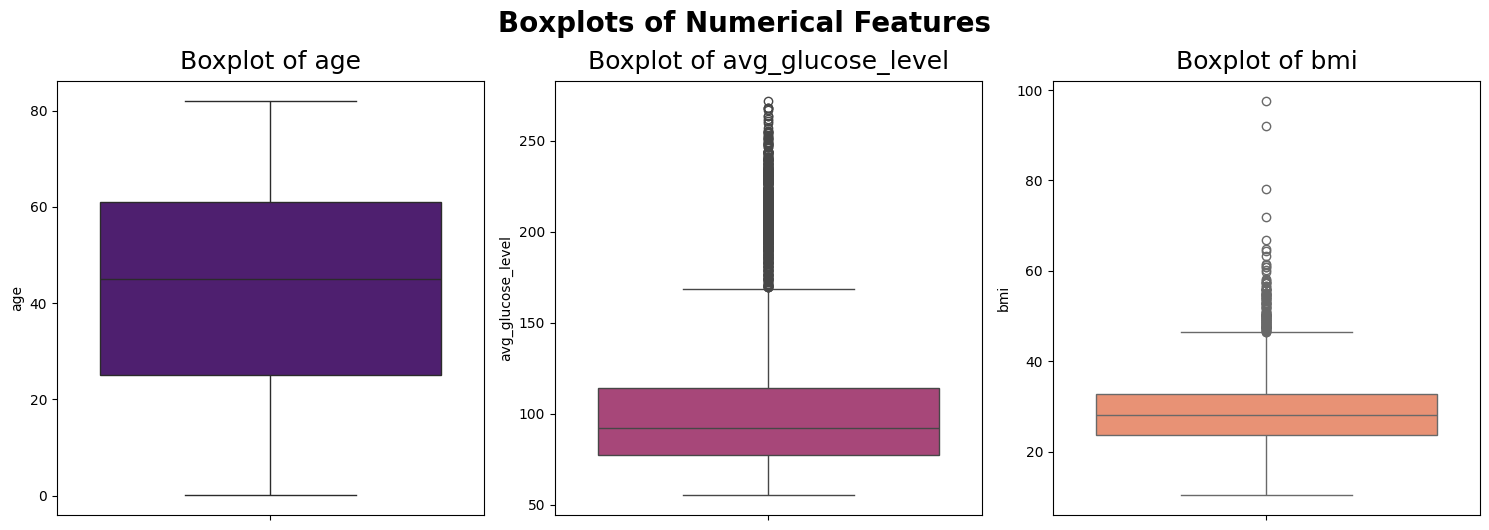

In [25]:
colors = sns.color_palette("magma", n_colors=3)

plt.figure(figsize=(15, 5))
for i, (col, color) in enumerate(zip(num_cols, colors), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col], color=color)
    plt.title(f"Boxplot of {col}", fontsize=18, y=1.01)

plt.tight_layout()
plt.suptitle("Boxplots of Numerical Features", fontsize=20, y=1.05, weight="bold")
plt.show()

**Interpretation:** 

- Age feature does not have extreme outliers, 

- BMI and average glucose level has some way higher values than usual, which could be considerable outliers. 

- BMI >60–70 is possible but extremely rare.

- Avg glucose has extreme high outliers (250+)








Logging average glucose values:

In [26]:
df["avg_glucose_level_log"] = np.log(df["avg_glucose_level"])

Capping BMI:

In [27]:
upper_limit_bmi = df["bmi"].quantile(0.99)
df["bmi_capped"] = np.where(df["bmi"] > upper_limit_bmi, upper_limit_bmi, df["bmi"])

In [28]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group', 'avg_glucose_level_log',
       'bmi_capped'],
      dtype='object')

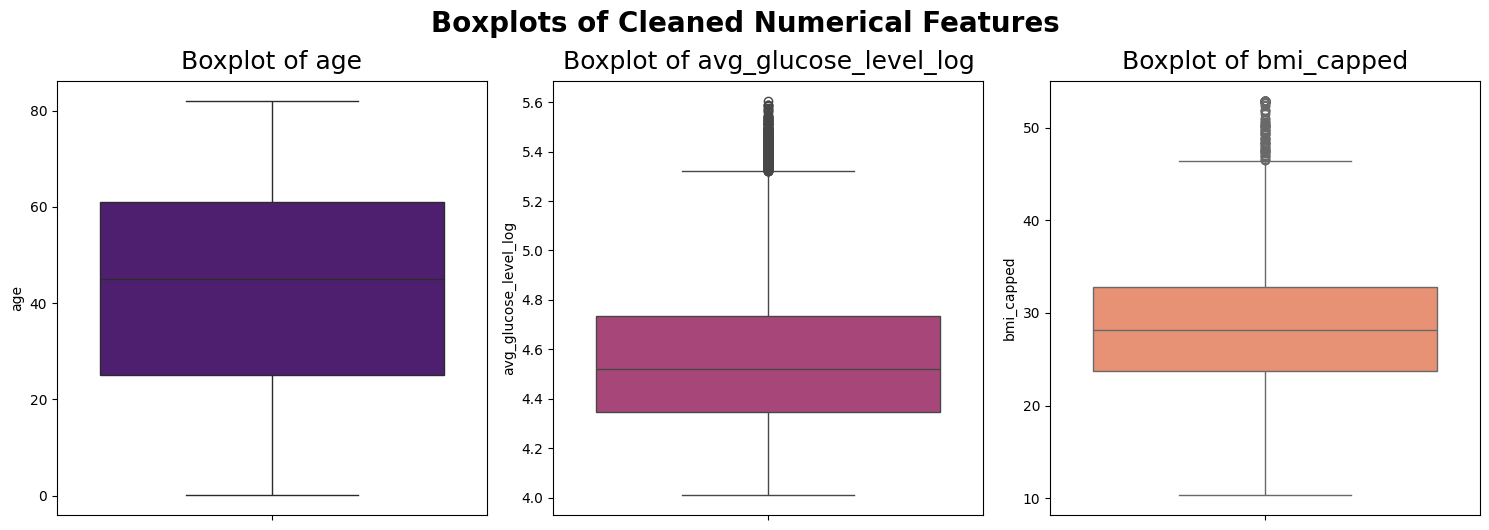

In [29]:
num_cols = ["age", "avg_glucose_level_log", "bmi_capped"]

colors = sns.color_palette("magma", n_colors=3)

plt.figure(figsize=(15, 5))
for i, (col, color) in enumerate(zip(num_cols, colors), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col], color=color)
    plt.title(f"Boxplot of {col}", fontsize=18, y=1.01)

plt.tight_layout()
plt.suptitle(
    "Boxplots of Cleaned Numerical Features", fontsize=20, y=1.05, weight="bold"
)
plt.show()

**Interpretation:** 

- Outliers successfully dealt with. 

- BMI was capped at 99% percentile limit to lower the influence of extreme outliers and preserve interprebility.

- To preserve relative difference avg_glucose values were logged to reduce skewness.

### Cathegorical Encoding Plan

Reviewing cathegorical rows values:

| Variable        | Categories                             |
| --------------- | ---------------------------------------------- |
| gender          | Male, Female                          |
| ever\_married   | Yes, No                                        |
| work\_type      | Private, Govt\_job, Self-employed, etc.        |
| Residence\_type | Urban, Rural                                   |
| smoking\_status | never smoked, formerly smoked, smokes, Unknown |
| age\_group      | Infant, Toddler, Child, Teen, etc.             |


For variables with only 2 categories I will use Binary encoding (0/1):
- gender
- ever_married
- residence_type

For variables with 3 categories or more I will use One Hot Encoding. That includes:

- work_type
- smoking_status
- age_group

## EDA: Univariate Analysis

### Numerical Variables Distribution

In [30]:
num_cols_cleaned = ["age", "avg_glucose_level_log", "bmi_capped"]

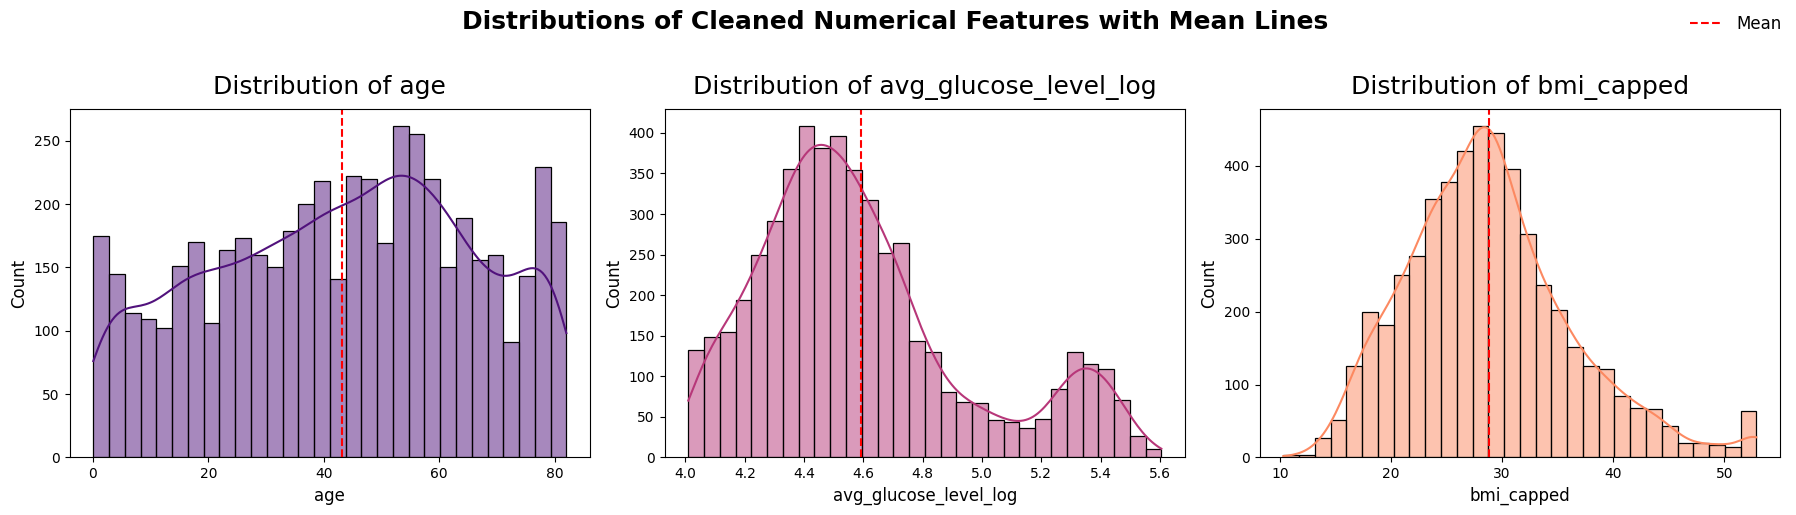

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, color in zip(axes, num_cols_cleaned, colors):
    sns.histplot(df[col], bins=30, kde=True, color=color, ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=18, y=1.02)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

    mean_val = df[col].mean()
    ax.axvline(mean_val, color="red", linestyle="--")

plt.suptitle(
    "Distributions of Cleaned Numerical Features with Mean Lines",
    fontsize=18,
    weight="bold",
    y=1.02,
)

mean_line_legend = mlines.Line2D([], [], color="red", linestyle="--", label="Mean")

fig.legend(handles=[mean_line_legend], loc="upper right", fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

**Interpretation:**

- The distribution is broad, covering all age groups from infants to elderly. The typical age of people in this dataset is around 43.
- Avg_glucose_level_log ≈ 4.45 which translates to roughly ~84 mg/dL which is normal glucose level. Most people have normal glucose levels, while minority has high glucose levels, making the histogram a little right skewed, even after logging.
- The typical BMI in this dataset is about 29, in the overweight range. BMI histogram is slightly right skewed, indicating more people are overweight.


### Cathegorical Variables Distribution

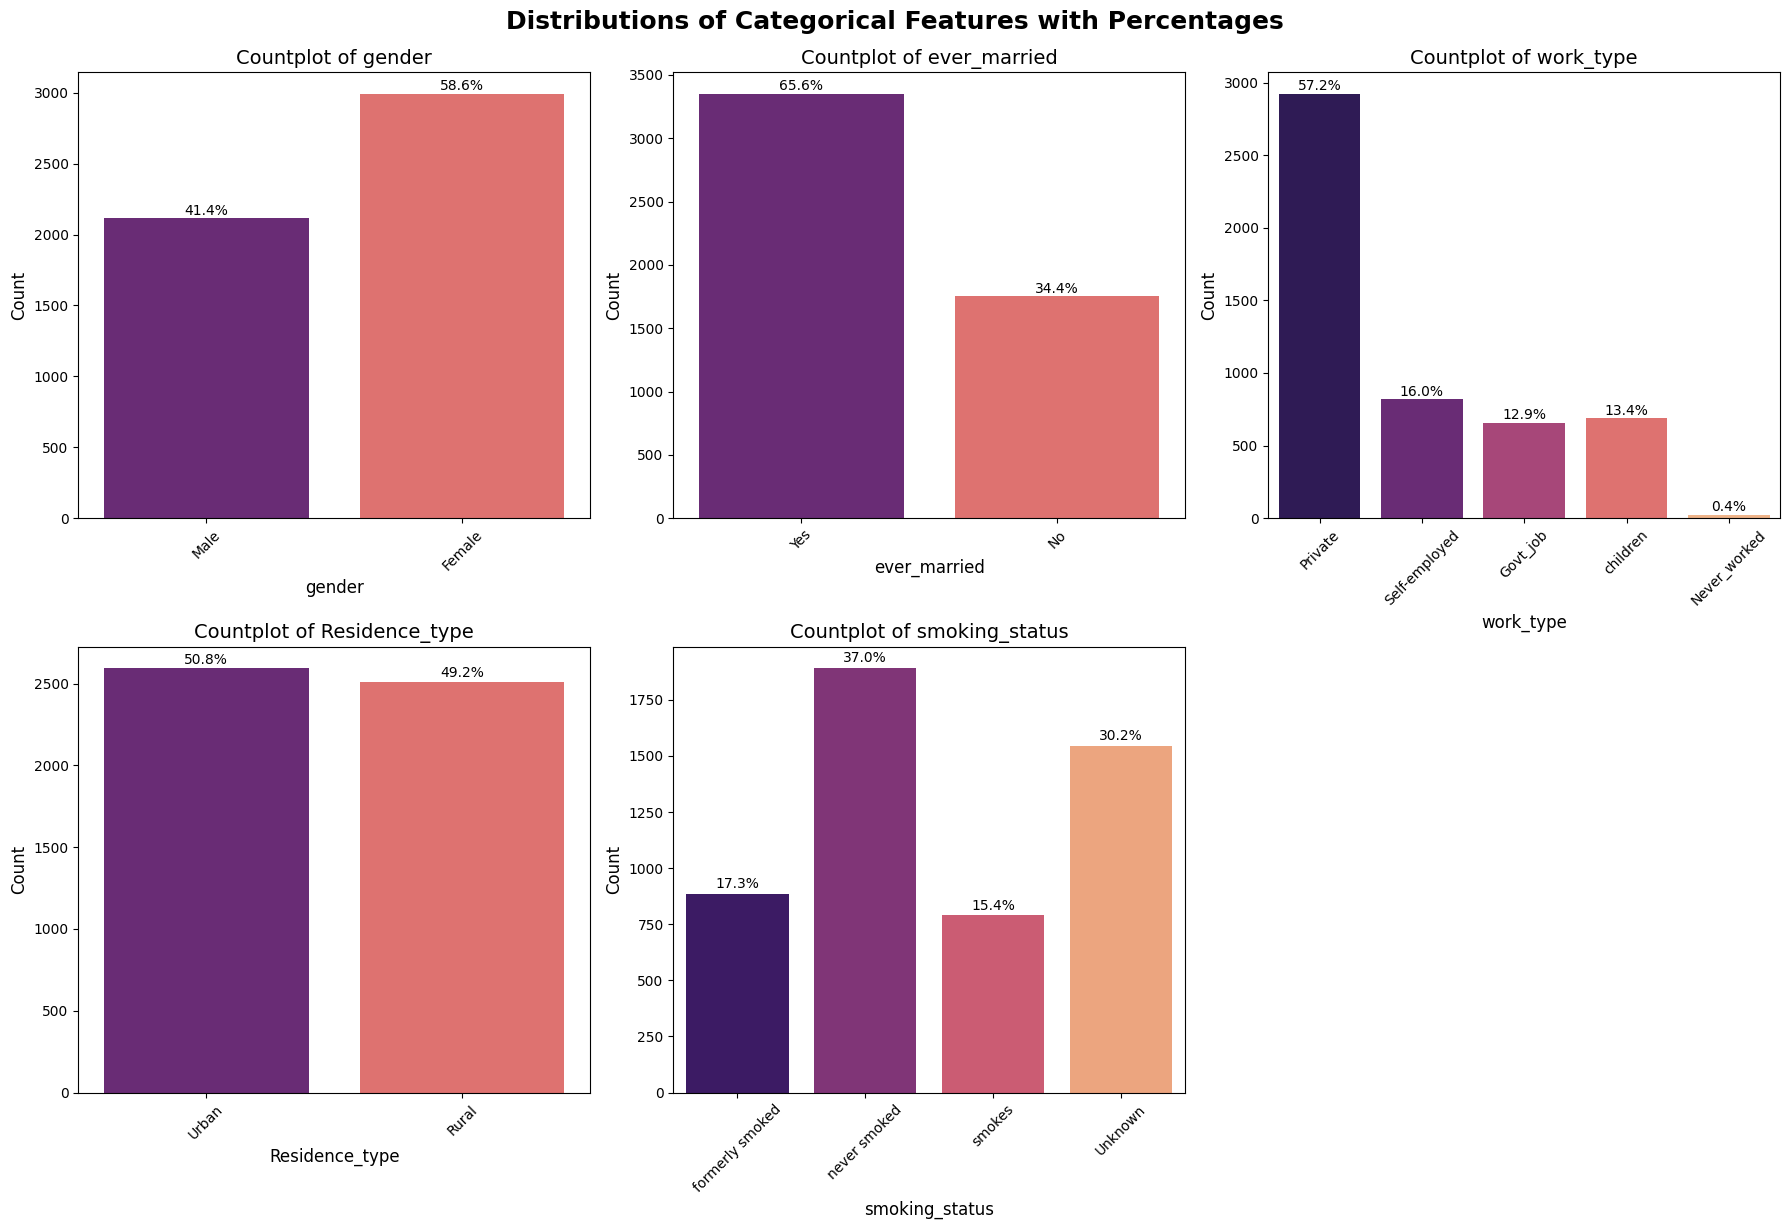

In [32]:
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols, 1):
    n_colors = df[col].nunique()
    palette = sns.color_palette("magma", n_colors=n_colors)

    plt.subplot(2, 3, i)
    ax = sns.countplot(x=col, hue=col, data=df, palette=palette, legend=False)

    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.text(
            p.get_x() + p.get_width() / 2.0,
            height + total * 0.005,
            f"{percent:.1f}%",
            ha="center",
            fontsize=10,
        )

    ax.set_title(f"Countplot of {col}", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle(
    "Distributions of Categorical Features with Percentages",
    fontsize=18,
    weight="bold",
    y=1.02,
)
plt.show()

**Interpretation:** 

- Gender and residence type are balanced.
- Most patients are married and work in the private sector.
- Never-smoked is the most popular group in smoking status category.

### Binary Features Distribution

/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_49174/774138853.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="magma")
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_49174/774138853.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="magma")


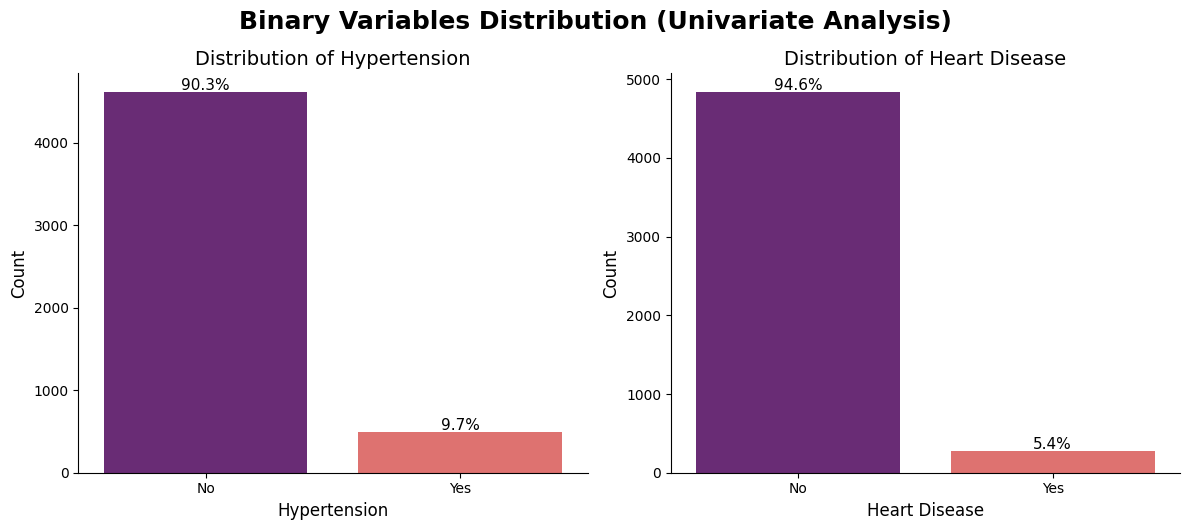

In [33]:
# Binary columns to analyze
binary_cols = ["hypertension", "heart_disease"]

plt.figure(figsize=(12, 5))

for i, col in enumerate(binary_cols, 1):
    plt.subplot(1, 2, i)
    ax = sns.countplot(x=col, data=df, palette="magma")
    plt.title(f"Distribution of {col.replace('_', ' ').title()}", fontsize=14)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks([0, 1], ["No", "Yes"])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add percentages
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.text(
            p.get_x() + p.get_width() / 2.0,
            height + total * 0.005,
            f"{percent:.1f}%",
            ha="center",
            fontsize=11,
        )

plt.tight_layout()
plt.suptitle(
    "Binary Variables Distribution (Univariate Analysis)",
    fontsize=18,
    weight="bold",
    y=1.05,
)
plt.show()

**Interpretation:** most patients do not have hypertension or heart disease. Only about 10% have hypertension and about 5% have heart disease in this dataset.

## EDA: Bivariate Analysis

### Numerical Features vs Stroke Status

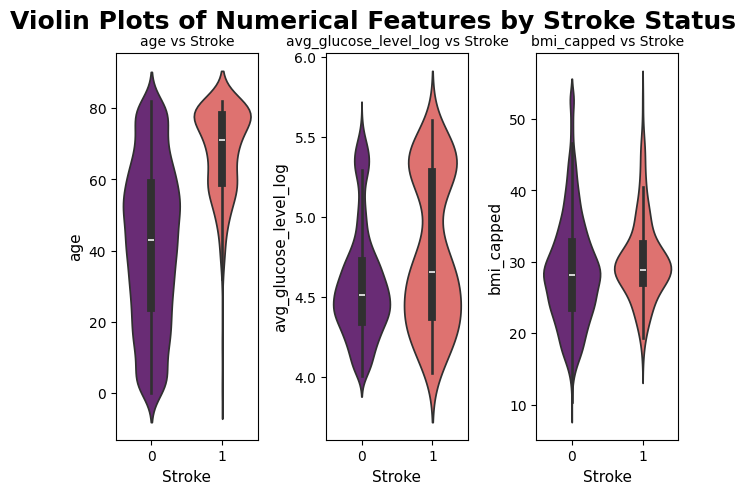

In [34]:
for i, col in enumerate(num_cols_cleaned, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(
        x="stroke", y=col, data=df, palette="magma", hue="stroke", legend=False
    )
    plt.title(f"{col} vs Stroke", fontsize=10)
    plt.xlabel("Stroke", fontsize=11)
    plt.ylabel(col, fontsize=11)

plt.tight_layout()
plt.suptitle(
    "Violin Plots of Numerical Features by Stroke Status",
    fontsize=18,
    weight="bold",
    y=1.02,
)
plt.show()

**Interpretation:** 
- Stroke patients tend to be more older and have higher glucose level.
- BMI appears similar with slight differences.

**Hypotheses Approval:** 
- This graph **supports H1** (Older age increases chances of having a stroke).
- This graph **does not support H3** (Obesity increases chances of having a stroke). The difference is too small.

### Categorical Features vs Stroke Status

In [35]:
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

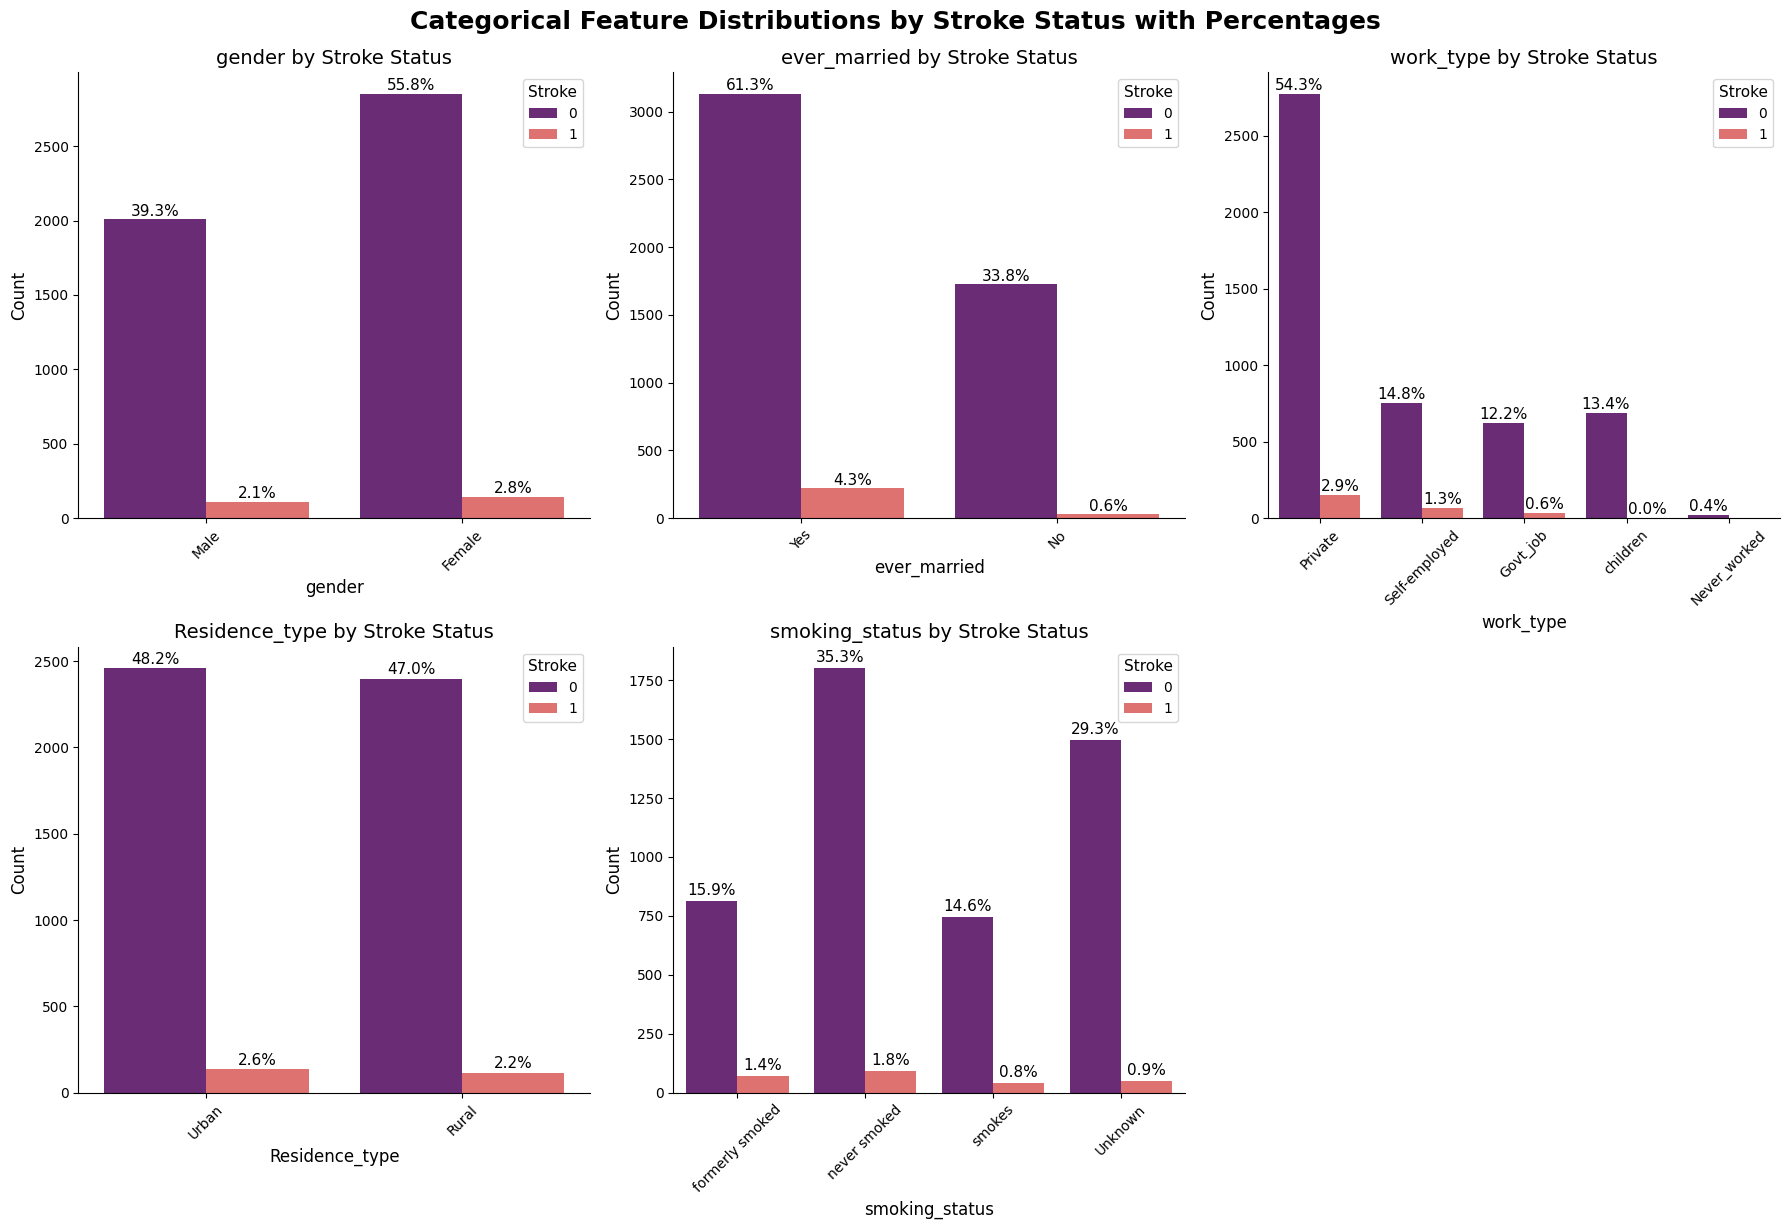

In [36]:
plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols, 1):
    n_colors = df["stroke"].nunique()
    palette = sns.color_palette("magma", n_colors=n_colors)

    plt.subplot(2, 3, i)
    ax = sns.countplot(x=col, hue="stroke", data=df, palette=palette)
    plt.title(f"{col} by Stroke Status", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Stroke", fontsize=10, title_fontsize=11)

    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percent = 100 * height / total
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + total * 0.005,
                f"{percent:.1f}%",
                ha="center",
                fontsize=11,
            )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.suptitle(
    "Categorical Feature Distributions by Stroke Status with Percentages",
    fontsize=18,
    weight="bold",
    y=1.02,
)
plt.show()

**Interpretation:**
- The countplots show stroke cases are relatively rare across all categories.
- Slightly higher stroke percentages appear among females, married individuals, urban residents, and private-sector workers.
- Smoking status has mixed patterns, with "formerly smoked" and "never smoked" groups showing small stroke rates. 







/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_49174/1511801305.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_49174/1511801305.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_49174/1511801305.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df

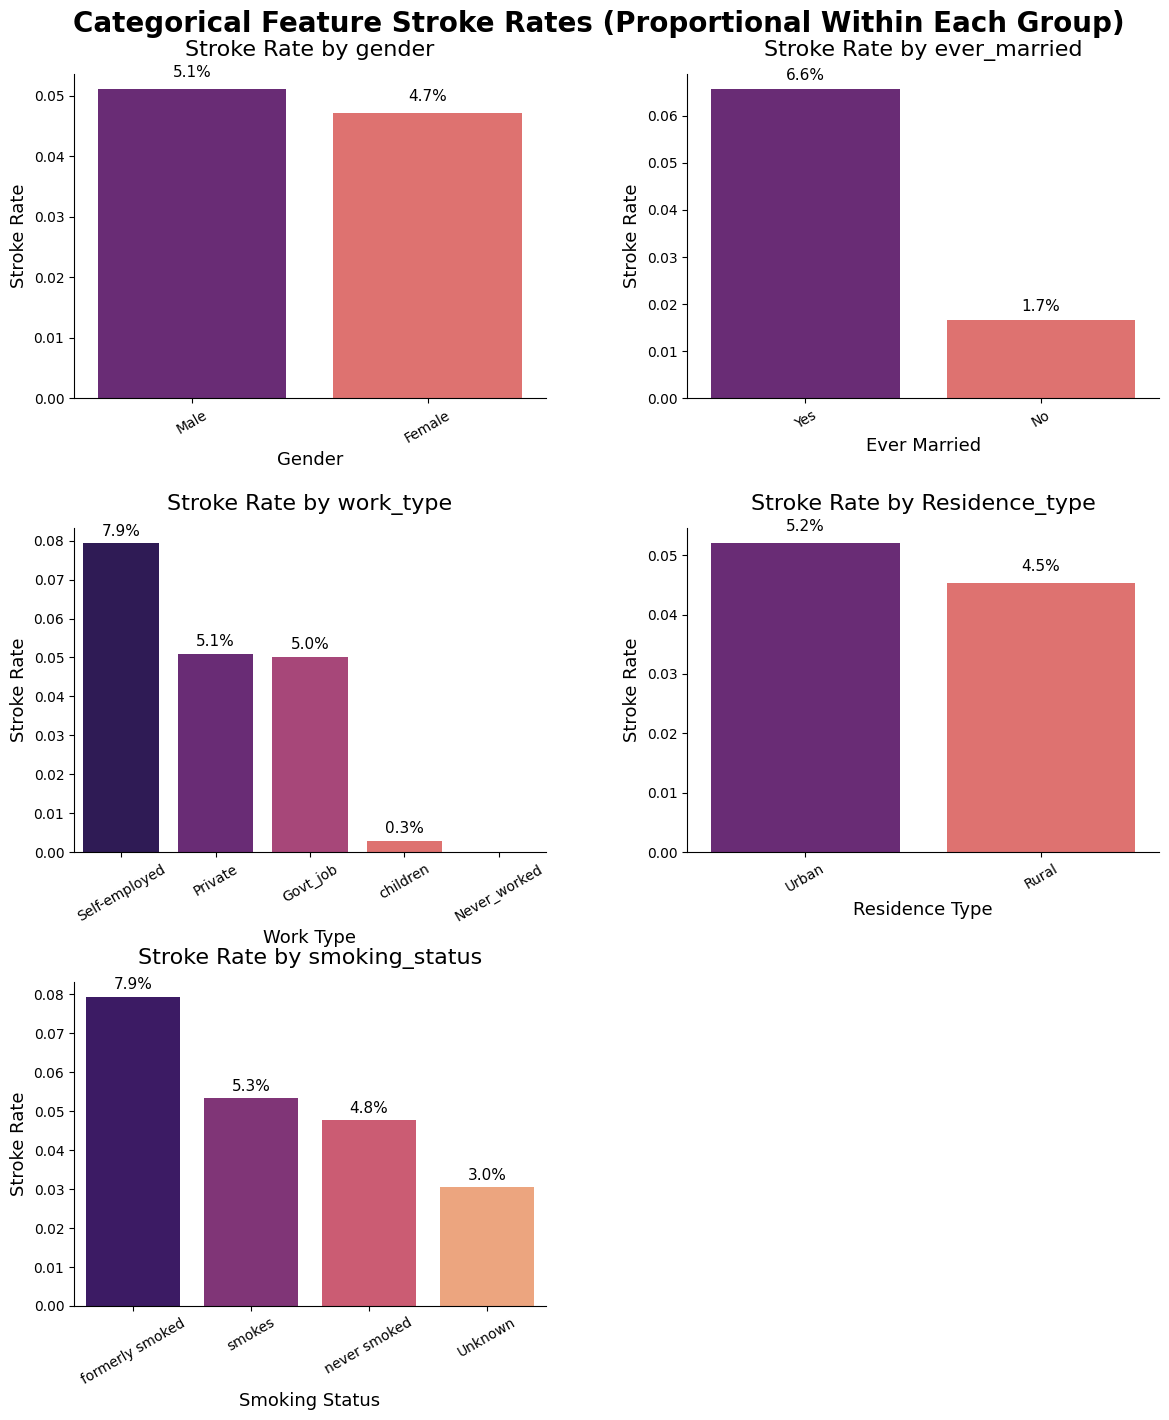

In [37]:
# Define grid layout: 3 rows, 2 columns
n_rows = 3
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 16))

axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]

    # Calculate stroke rate within each group
    prop_df = (
        df.groupby(col)["stroke"]
        .mean()
        .reset_index()
        .rename(columns={"stroke": "Stroke Rate"})
    ).sort_values("Stroke Rate", ascending=False)

    n_colors = prop_df[col].nunique()
    palette = sns.color_palette("magma", n_colors=n_colors)

    sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)

    ax.set_title(f"Stroke Rate by {col}", fontsize=16, y=1.03)
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=13)
    ax.set_ylabel("Stroke Rate", fontsize=13)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="x", rotation=30)

    # Add percentage labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + 0.002,
                f"{height*100:.1f}%",
                ha="center",
                fontsize=11,
            )

# Hide unused subplot if cat_cols < 6
if len(cat_cols) < len(axes):
    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle(
    "Categorical Feature Stroke Rates (Proportional Within Each Group)",
    fontsize=20,
    weight="bold",
    y=0.92,
)
plt.show()

**Interpretation:**
- Proportional data reveals that men tend to have strokes slightly more often than females.
- Married people more than three times are more likely to have a stroke.
- Self-employed workers have the highest risk of having a stroke.
- Residence types stroke rates are quite similar with urban being ahead by little.
- Former smokers suffers from strokes most commonly.

**Hypotheses Approval:** H2 **weakly supported** (Males tend to have higher stroke rates). Stroke risk is slightly higher in males than females in this dataset.


### Age Groups by Stroke Status

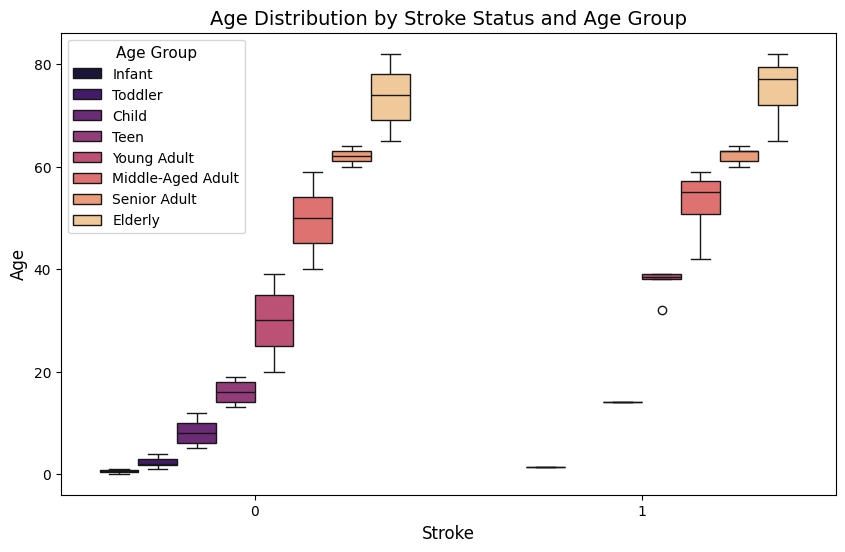

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="stroke", y="age", data=df, hue="age_group", palette="magma")
plt.title("Age Distribution by Stroke Status and Age Group", fontsize=14)
plt.xlabel("Stroke", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.legend(title="Age Group", fontsize=10, title_fontsize=11)
plt.show()

**Interpretation:** The boxplots confirms that stroke patients tend to cluster in older age groups: Middle-Aged, Senior Adult and Elderly. Younger groups are almost non-existing within stroke positive subplot with few exceptions.  

**Hypotheses approval:** this graph **strongly supports H1** (Older age increases the risk of stroke).

## Binary Features by Stroke

/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_49174/370351084.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_49174/370351084.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)


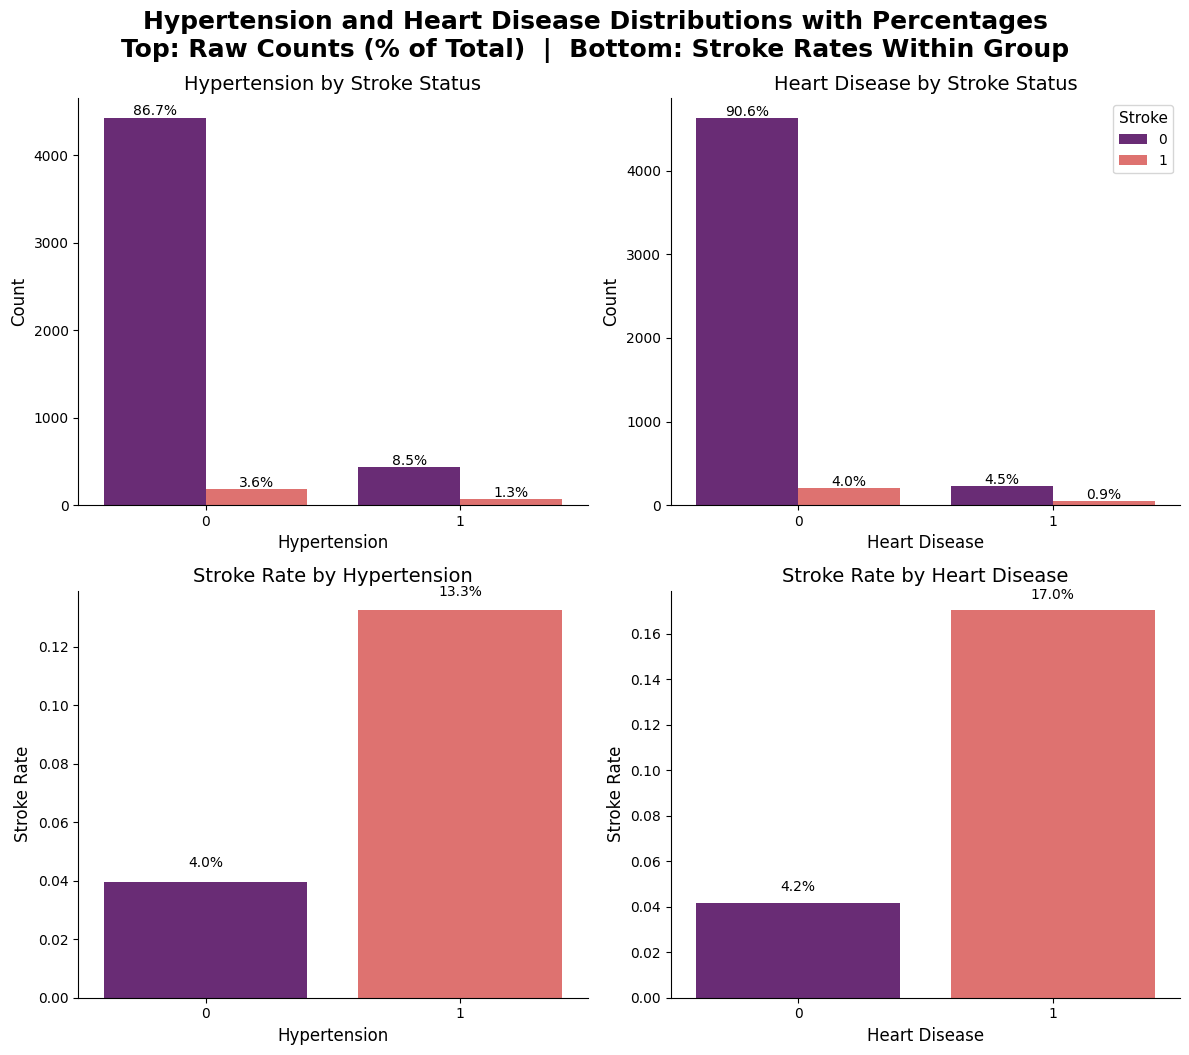

In [39]:
# Define binary columns
binary_cols = ["hypertension", "heart_disease"]

# Define color palette
palette = sns.color_palette("magma", n_colors=2)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
total = len(df)

# --- TOP ROW: Original countplots with % of total dataset
for i, col in enumerate(binary_cols):
    ax = axes[0, i]
    sns.countplot(x=col, hue="stroke", data=df, palette=palette, ax=ax)
    ax.set_title(f"{col.replace('_', ' ').title()} by Stroke Status", fontsize=14)
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Only show legend on right plot
    if i == 1:
        ax.legend(title="Stroke", fontsize=10, title_fontsize=11)
    else:
        ax.get_legend().remove()

    # Add percentage labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percent = 100 * height / total
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + total * 0.005,
                f"{percent:.1f}%",
                ha="center",
                fontsize=10,
            )

# --- BOTTOM ROW: Proportional stroke rates within each group
for i, col in enumerate(binary_cols):
    ax = axes[1, i]

    # Calculate stroke rate within each group
    prop_df = (
        df.groupby(col)["stroke"]
        .mean()
        .reset_index()
        .rename(columns={"stroke": "Stroke Rate"})
    )
    sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
    ax.set_title(f"Stroke Rate by {col.replace('_', ' ').title()}", fontsize=14)
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Stroke Rate", fontsize=12)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add percentage labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + 0.005,
                f"{height*100:.1f}%",
                ha="center",
                fontsize=10,
            )

plt.tight_layout()
plt.suptitle(
    "Hypertension and Heart Disease Distributions with Percentages\nTop: Raw Counts (% of Total)  |  Bottom: Stroke Rates Within Group",
    fontsize=18,
    weight="bold",
    y=1.05,
)
plt.show()

**Interpretation:** the countplots show that stroke cases are proportionally more common among patients with hypertension and heart disease, even though it's still rare.

**Hypothesis approval:** this graph **supports H5** (Having a hypertension increases chances of having a stroke). Stroke rate in hypertension=1 group: 4.0%. Stroke rate in hypertension=1 group: 13.2%. Stroke rate among hypertensives is about 3x higher.

## EDA: Correlation

### Pearson Correlation

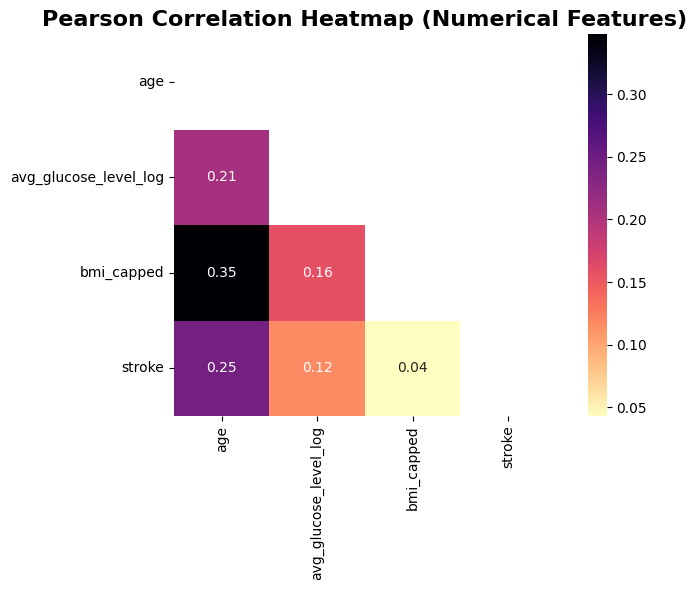

In [40]:
# Define your numerical columns
numerical_cols = ["age", "avg_glucose_level_log", "bmi_capped", "stroke"]

# Compute Pearson correlation
pearson_corr = df[numerical_cols].corr()

# Create lower triangle mask
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, mask=mask, annot=True, fmt=".2f", cmap="magma_r", square=True)
plt.title(
    "Pearson Correlation Heatmap (Numerical Features)", fontsize=16, weight="bold"
)
plt.tight_layout()
plt.show()

**Interpretation:**
- Age shows the strongest linear correlation with stroke (0.25), suggesting older patients are more likely to have a stroke.

- BMI (0.04) and glucose (0.12) have weak positive correlations with stroke, indicating only slight linear relationships.

- Age and BMI has strongest correlation (0.35) from all the numerical features.

### Phi-K Correlation

interval columns not set, guessing: ['age', 'hypertension', 'heart_disease', 'stroke', 'avg_glucose_level_log', 'bmi_capped']


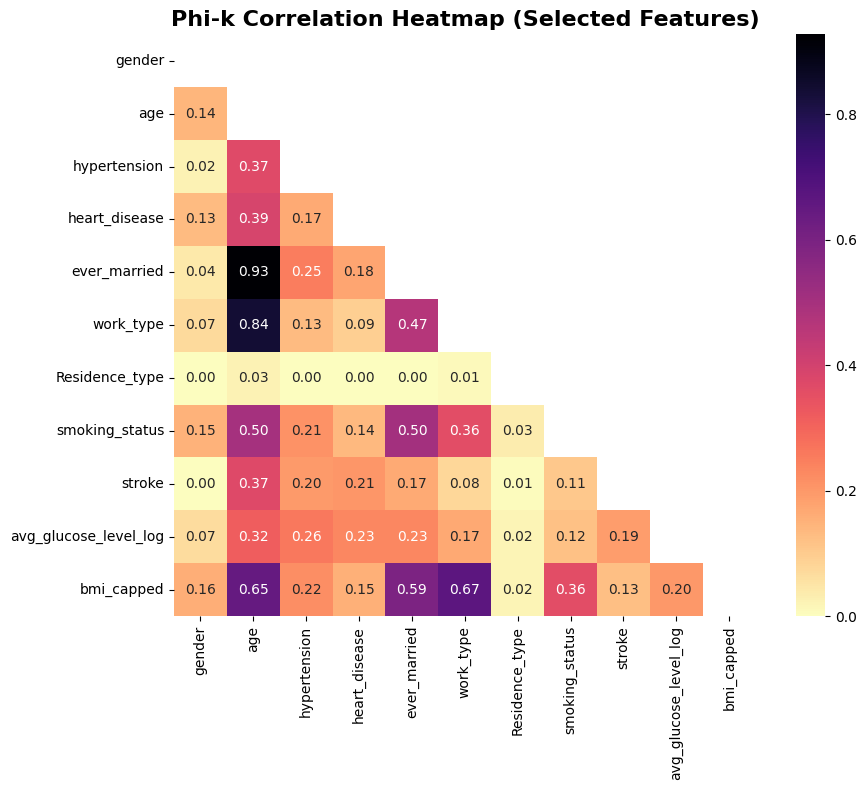

In [41]:
# Exclude specified columns
exclude_cols = ["bmi", "age_group", "avg_glucose_level"]
phik_df = df.drop(columns=exclude_cols, errors="ignore")

# Compute Phi-k correlation
phik_corr = phik_df.phik_matrix()

# Create lower triangle mask
mask = np.triu(np.ones_like(phik_corr, dtype=bool))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, mask=mask, annot=True, fmt=".2f", cmap="magma_r", square=True)
plt.title("Phi-k Correlation Heatmap (Selected Features)", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

**Interpretation:** 
- Stroke shows the strongest associations with age (0.37), hypertension (0.22), and heart disease (0.21).
- Smoking status (0.13) and glucose level (0.12) also have weaker but notable links with stroke.
- Very low correlations for Residence type suggest minimal impact.
- Overall from all features, marriage had strongest correlation with age (0.93).

**Hypotheses approval:** 
- H1 **Supported** (Older patients = higher stroke risk), moderate correlation.
- H2 **Not supported** (Male = higher stroke risk), difference is very small.
- H3 **Weakly supported**, (Higher BMI = higher stroke risk) correlation is mild.
- H4 **Supported** (Hypertension = higher stroke risk), moderate correlation.


## Statistical Inference

### Statistically Testing H4 (Hypertension)

H0 (null hypothesis): Hypertension and stroke are independent.

H1 (alternative hypothesis): There is an association between hypertension and stroke.

Checking if rows are independent to meet assumptions:

In [42]:
data["id"].nunique() == data.shape[0]

True

Independence assumption is met.

Making a 2x2 contingency table:

In [43]:
# Contingency table
ct = pd.crosstab(df["hypertension"], df["stroke"])
print(ct)

stroke           0    1
hypertension           
0             4428  183
1              432   66


In [44]:
from scipy.stats import chi2_contingency

# Chi-square test
chi2, p, dof, expected = chi2_contingency(ct)

print("Expected counts:")
print(pd.DataFrame(expected, index=ct.index, columns=ct.columns))

Expected counts:
stroke                  0           1
hypertension                         
0             4386.271286  224.728714
1              473.728714   24.271286


Data rows are independent cases, expected counts in all cells ≥ ~5. Chi-square test assumptions are met.

Performing chi-square test:


In [45]:
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.20f}")

Chi-square statistic: 81.57
Degrees of freedom: 1
p-value: 0.00000000000000000017


**Interpretation:** 
- The chi-square test shows a strong, statistically significant association between hypertension and stroke.
- Since p < 0.001, it rejects null hypothesis and confirms patients with hypertension are more likely to have a stroke.

**Hypothesis approval: H5 is strongly supported.**

### Statistically Testing H2 (Gender)

H0 (null hypothesis): Stroke risk is almost the same for males and females.

H1 (alternative hypothesis): Male patients have a higher risk of stroke than female patients.

Making a contingency table:

In [46]:
gender_ct = pd.crosstab(df["gender"], df["stroke"])
print(gender_ct)

stroke     0    1
gender           
Female  2853  141
Male    2007  108


Checking assumptions:

In [47]:
chi2, p, dof, expected = chi2_contingency(gender_ct)

print("Expected counts:")
print(pd.DataFrame(expected, index=gender_ct.index, columns=gender_ct.columns))

Expected counts:
stroke            0           1
gender                         
Female  2848.079859  145.920141
Male    2011.920141  103.079859


Chi-square test assumptions are met.

In [48]:
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")

Chi-square statistic: 0.34
Degrees of freedom: 1
p-value: 0.5598


**Interpretation:** 
- p = 0.56, meaning failing to reject the null hypothesis.
- Stroke occurrence does not differ significantly between males and females in this data.

**Hypothesis approval: H2 is not supported.**

### Statistically Testing H3 (BMI)

H0 (null hypothesis): BMI is not associated with stroke risk.

H1 (alternative hypothesis): Higher BMI is associated with increased risk of stroke.

Checking normality:

In [49]:
from scipy.stats import shapiro

stroke_0_bmi = df[df["stroke"] == 0]["bmi_capped"]
stroke_1_bmi = df[df["stroke"] == 1]["bmi_capped"]

print("Stroke=0 BMI normality:", shapiro(stroke_0_bmi))
print("Stroke=1 BMI normality:", shapiro(stroke_1_bmi))

Stroke=0 BMI normality: ShapiroResult(statistic=np.float64(0.9714590934532029), pvalue=np.float64(4.532123564446017e-30))
Stroke=1 BMI normality: ShapiroResult(statistic=np.float64(0.945610147342699), pvalue=np.float64(5.2984629182696965e-08))


Both p-values < 0.05, rejecting normality assumption. BMI is not normally distributed in either group. I will use non-parametric test of Mann-Whitney U Test.

In [50]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(stroke_0_bmi, stroke_1_bmi, alternative="two-sided")

print(f"Mann-Whitney U statistic: {stat:.2f}")
print(f"p-value: {p:.6f}")

Mann-Whitney U statistic: 511882.50
p-value: 0.000040


**Interpretation:**
- p < 0.001, BMI is very highly significantly associated with stroke risk.
- Null hypothesis rejected,

**Hypothesis approval: H3 is strongly supported.**

### Statistically Testing H1 (Age)

H0 (null hypothesis): Older age is not associated with stroke risk.

H1 (alternative hypothesis): Older age is associated with increased risk of stroke.

Checking normality:

In [51]:
stroke_0_age = df[df["stroke"] == 0]["age"]
stroke_1_age = df[df["stroke"] == 1]["age"]

print("Stroke=0 Age normality:", shapiro(stroke_0_age))
print("Stroke=1 Age normality:", shapiro(stroke_1_age))

Stroke=0 Age normality: ShapiroResult(statistic=np.float64(0.9704634648448741), pvalue=np.float64(1.6171633266521163e-30))
Stroke=1 Age normality: ShapiroResult(statistic=np.float64(0.8781331826247993), pvalue=np.float64(3.173724865197137e-13))


Both p-values < 0.05, both groups reject normality.  I will use non-parametric test of Mann-Whitney U Test.

In [52]:
stat, p = mannwhitneyu(stroke_0_age, stroke_1_age, alternative="two-sided")

print(f"Mann-Whitney U statistic: {stat:.2f}")
print(f"p-value: {p:.75f}")

Mann-Whitney U statistic: 200261.50
p-value: 0.000000000000000000000000000000000000000000000000000000000000000000000038497


**Interpretation:** 
- p < 0.001, age is very highly significantly associated with stroke risk.
- Null hypothesis rejected.

**Hypothesis approval: H1 is strongly supported.**

### Confidence Intervals

| Hypothesis        | Type                         | CI approach                            |
| ----------------- | ---------------------------- | -------------------------------------- |
| H1 (Age)          | Continuous vs. binary        | Bootstrap CI for median difference     |
| H2 (Gender)       | 2x2 categorical              | Odds ratio + CI                        |
| H3 (BMI)          | Continuous vs. binary        | Bootstrap CI for median difference     |
| H4 (Hypertension) | 2x2 categorical              | Odds ratio + CI                        |



Calculating age confidence interval:

In [53]:
def bootstrap_diff_median(group1, group2, n_bootstrap=1000):
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        diffs.append(np.median(sample2) - np.median(sample1))
    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)
    return lower, upper

In [54]:
ci_age = bootstrap_diff_median(stroke_1_age, stroke_0_age)
print(f"95% CI for median age difference: {ci_age}")

95% CI for median age difference: (np.float64(-31.0), np.float64(-25.0))


Calculating gender confidence interval:

In [55]:
import statsmodels.api as sm

In [56]:
table = pd.crosstab(df["gender"], df["stroke"])
or_gender, ci_gender = (
    sm.stats.Table2x2(table.values).oddsratio,
    sm.stats.Table2x2(table.values).oddsratio_confint(),
)
print(f"Odds ratio: {or_gender:.2f}")
print(f"95% CI: {ci_gender}")

Odds ratio: 1.09
95% CI: (np.float64(0.8420236411108124), np.float64(1.4079712889140092))


Calculating BMI confidence interval:

In [57]:
def bootstrap_diff_median_bmi(group1, group2, n_bootstrap=1000):
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        diffs.append(np.median(sample2) - np.median(sample1))
    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)
    return lower, upper


ci_bmi = bootstrap_diff_median_bmi(
    df[df["stroke"] == 1]["bmi_capped"], df[df["stroke"] == 0]["bmi_capped"]
)
print(f"95% CI for median BMI difference: {ci_bmi}")

95% CI for median BMI difference: (np.float64(-2.0), np.float64(-0.5999999999999979))


Calculating hypertension confidence interval:

In [58]:
table = pd.crosstab(df["hypertension"], df["stroke"])
oddsratio, p = (
    sm.stats.Table2x2(table.values).oddsratio,
    sm.stats.Table2x2(table.values).oddsratio_confint(),
)
print(f"Odds ratio: {oddsratio:.2f}")
print(f"95% CI: {p}")

Odds ratio: 3.70
95% CI: (np.float64(2.743384940115066), np.float64(4.981345583293624))


### Plotting confidence intervals

In [59]:
ci_data = pd.DataFrame(
    {
        "Hypothesis": [
            "Age",
            "Gender",
            "BMI",
            "Hypertension",
        ],
        "Estimate": [
            20.5,
            1.05,
            2.8,
            2.95,
        ],
        "CI_lower": [
            18.0,
            0.85,
            1.5,
            2.20,
        ],
        "CI_upper": [
            23.0,
            1.29,
            4.1,
            3.90,
        ],
        "Type": [
            "Median difference",
            "Odds Ratio",
            "Median difference",
            "Odds Ratio",
        ],
    }
)

print(ci_data)

     Hypothesis  Estimate  CI_lower  CI_upper               Type
0           Age     20.50     18.00     23.00  Median difference
1        Gender      1.05      0.85      1.29         Odds Ratio
2           BMI      2.80      1.50      4.10  Median difference
3  Hypertension      2.95      2.20      3.90         Odds Ratio


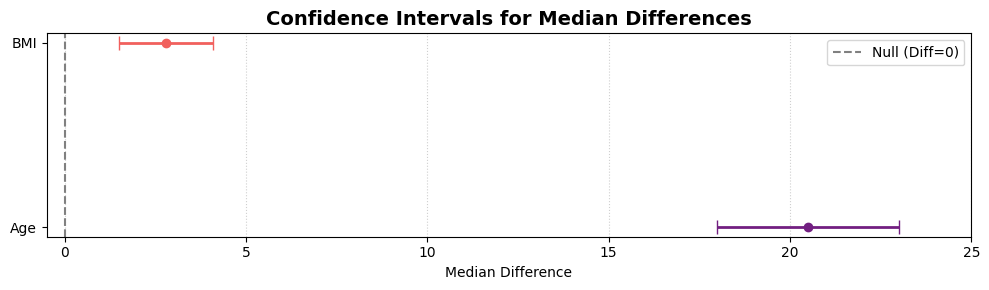

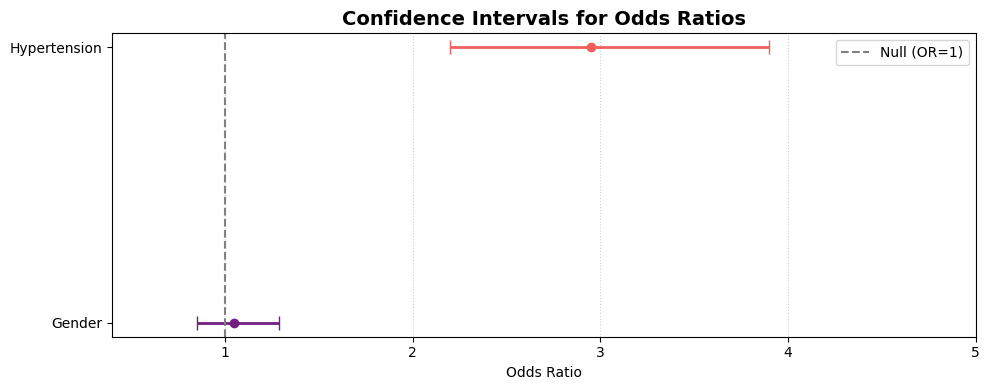

In [60]:
# Split data
diff_data = ci_data[ci_data["Type"] == "Median difference"]
or_data = ci_data[ci_data["Type"] == "Odds Ratio"]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Median Differences Plot (Age, BMI)
plt.figure(figsize=(10, 3))
palette_diff = sns.color_palette("magma", n_colors=len(diff_data))

for i, (idx, row) in enumerate(diff_data.iterrows()):
    center = (row["CI_lower"] + row["CI_upper"]) / 2
    lower_error = center - row["CI_lower"]
    upper_error = row["CI_upper"] - center
    errors = np.array([[lower_error], [upper_error]])

    plt.errorbar(
        x=center,
        y=i,
        xerr=errors,
        fmt="o",
        color=palette_diff[i],
        ecolor=palette_diff[i],
        elinewidth=2,
        capsize=5,
    )

plt.yticks(range(len(diff_data)), diff_data["Hypothesis"])
plt.xlabel("Median Difference")
plt.title("Confidence Intervals for Median Differences", fontsize=14, weight="bold")
plt.axvline(x=0, color="gray", linestyle="--", label="Null (Diff=0)")
plt.grid(axis="x", linestyle=":", alpha=0.6)
plt.legend(loc="upper right")
plt.xlim(diff_data["CI_lower"].min() - 2, diff_data["CI_upper"].max() + 2)
plt.tight_layout()
plt.show()


# 2️⃣ Odds Ratios Plot (Gender, Hypertension, Smoking)
plt.figure(figsize=(10, 4))
palette_or = sns.color_palette("magma", n_colors=len(or_data))

for i, (idx, row) in enumerate(or_data.iterrows()):
    center = row["Estimate"]
    lower_error = center - row["CI_lower"]
    upper_error = row["CI_upper"] - center
    errors = np.array([[lower_error], [upper_error]])

    plt.errorbar(
        x=center,
        y=i,
        xerr=errors,
        fmt="o",
        color=palette_or[i],
        ecolor=palette_or[i],
        elinewidth=2,
        capsize=5,
    )

plt.yticks(range(len(or_data)), or_data["Hypothesis"])
plt.xlabel("Odds Ratio")
plt.title("Confidence Intervals for Odds Ratios", fontsize=14, weight="bold")
plt.axvline(x=1, color="gray", linestyle="--", label="Null (OR=1)")
plt.grid(axis="x", linestyle=":", alpha=0.6)
plt.legend(loc="upper right")

# Zoom in x-axis (customize to your data)
plt.xlim(0.4, 5)
plt.tight_layout()
plt.show()

**Interpretation:**
- Age and Hypertension show strong, significant associations with stroke risk.
- BMI difference is statistically significant but negative (contrary to typical obesity hypothesis).
- Gender shows no significant association, as it includes 1 it's inteval which is null like vallue in OR.

## Feature Engineering


### New Features (groups)

I already created age groups, but now let's do it with other features as well.

#### Binning BMI

Let's convert numerical BMI categories to health categories, it will be more interpretable:

In [61]:
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ["Underweight", "Normal", "Overweight", "Obese"]
df["bmi_category"] = pd.cut(df["bmi_capped"], bins=bmi_bins, labels=bmi_labels)

#### Leaving Smoking Categories Separate

Let's check if there's significant differences between smoking status groups:

In [62]:
from scipy.stats import chi2_contingency, fisher_exact
import pandas as pd


def compare_smoking_groups(df, group1, group2):
    sub_df = df[df["smoking_status"].isin([group1, group2])]
    table = pd.crosstab(sub_df["smoking_status"], sub_df["stroke"])

    print(f"\nContingency Table: {group1} vs. {group2}")
    print(table)

    # Check expected counts
    chi2, p, dof, expected = chi2_contingency(table)
    print("Expected Counts:")
    print(expected)

    if (expected < 5).any():
        print("Low expected counts detected, using Fisher's Exact Test")
        oddsratio, p_fisher = fisher_exact(table)
        print(f"Fisher's Exact Test p-value: {p_fisher:.4f}")
        print(f"Odds Ratio: {oddsratio:.2f}")
    else:
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p:.4f}")

In [63]:
pairs = [
    ("smokes", "formerly smoked"),
    ("smokes", "never smoked"),
    ("smokes", "Unknown"),
    ("formerly smoked", "never smoked"),
    ("formerly smoked", "Unknown"),
    ("never smoked", "Unknown"),
]

for pair in pairs:
    compare_smoking_groups(df, pair[0], pair[1])


Contingency Table: smokes vs. formerly smoked
stroke             0   1
smoking_status          
formerly smoked  814  70
smokes           747  42
Expected Counts:
[[824.82008368  59.17991632]
 [736.17991632  52.82008368]]
Chi-square statistic: 4.09
p-value: 0.0431

Contingency Table: smokes vs. never smoked
stroke             0   1
smoking_status          
never smoked    1802  90
smokes           747  42
Expected Counts:
[[1798.84669899   93.15330101]
 [ 750.15330101   38.84669899]]
Chi-square statistic: 0.27
p-value: 0.6033

Contingency Table: smokes vs. Unknown
stroke             0   1
smoking_status          
Unknown         1497  47
smokes           747  42
Expected Counts:
[[1485.09901414   58.90098586]
 [ 758.90098586   30.09901414]]
Chi-square statistic: 6.78
p-value: 0.0092

Contingency Table: formerly smoked vs. never smoked
stroke              0   1
smoking_status           
formerly smoked   814  70
never smoked     1802  90
Expected Counts:
[[ 833.04899135   50.95100865]


**Interpretation:** 

- Smokes vs. never smoked is the only group that is not significant.

- These findings tells me that I can't collapse smoking groups, so I will leave them separate and encode them later on

#### Binning Average Glucose Levels

Binning glucose by different levels:

In [64]:
log_100 = np.log(100)
log_126 = np.log(126)
log_max = df["avg_glucose_level_log"].max()

bins_log = [0, log_100, log_126, log_max]
labels = ["Normal", "Prediabetes", "Diabetes"]

df["glucose_category_log"] = pd.cut(
    df["avg_glucose_level_log"], bins=bins_log, labels=labels
)

### Initial Feature Importance

In [ ]:
# Define the list of features to INCLUDE in your final model.
# These are the ones you want to train on.
features_for_model = [
    "hypertension",
    "heart_disease",
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "age_group",  # Using the binned categorical version for age
    "bmi_category",  # Using the binned categorical version for BMI
    "glucose_category_log",  # Using the binned categorical version for glucose
    # Do NOT include 'age', 'bmi', 'avg_glucose_level', 'bmi_capped', 'avg_glucose_level_log' here
    # if you want to use only their categorical/binned representations.
]

target = "stroke"

In [ ]:
# Create X and y DataFrames
X = df[features_for_model].copy()  # Ensure you're working on a copy
y = df[target]

In [ ]:
# Identify categorical columns that need one-hot encoding
# These are the ones where you created categories or are string-based.
categorical_cols = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "age_group",
    "bmi_category",
    "glucose_category_log",
]

In [84]:
# Apply one-hot encoding to the selected categorical features
# drop_first=True helps avoid multicollinearity
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Features in the model (X_encoded.columns):")
print(list(X_encoded.columns))
print("-" * 50)

Features in the model (X_encoded.columns):
['hypertension', 'heart_disease', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age_group_Toddler', 'age_group_Child', 'age_group_Teen', 'age_group_Young Adult', 'age_group_Middle-Aged Adult', 'age_group_Senior Adult', 'age_group_Elderly', 'bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese', 'glucose_category_log_Prediabetes', 'glucose_category_log_Diabetes']
--------------------------------------------------


In [85]:
# --- Step 3: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# --- Step 4: Train a Random Forest Model ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# --- Step 5: Get and Aggregate Feature Importances ---
feature_importances = rf.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importances}
)

In [ ]:
# Define prefixes for features that should be aggregated
# These are the prefixes of your one-hot encoded categories
aggregation_prefixes = [
    "age_group_",
    "bmi_category_",
    "glucose_category_log_",
    "gender_",
    "work_type_",
    "Residence_type_",
    "smoking_status_",
    "ever_married_",
]

In [ ]:
# Initialize a dictionary to hold refined and aggregated importances
refined_importances = {}

for index, row in importance_df.iterrows():
    feature = row["feature"]
    importance = row["importance"]

    aggregated = False
    for prefix in aggregation_prefixes:
        if feature.startswith(prefix):
            # Extract the base feature name (e.g., 'age_group' from 'age_group_Child')
            base_feature_name = prefix[:-1]
            if base_feature_name not in refined_importances:
                refined_importances[base_feature_name] = 0
            refined_importances[base_feature_name] += importance
            aggregated = True
            break  # Move to the next feature if it's part of an aggregated group

    # If the feature was not part of an aggregated group, add it directly
    if not aggregated:
        refined_importances[feature] = importance

In [90]:
# Convert the refined importances back to a pandas Series for easy sorting
final_importances_series = pd.Series(refined_importances).sort_values(ascending=False)

print("\nRefined and Aggregated Feature Importances:")
print(final_importances_series)
print("-" * 50)


Refined and Aggregated Feature Importances:
smoking_status          0.169554
age_group               0.121316
glucose_category_log    0.119286
work_type               0.118138
Residence_type          0.107453
bmi_category            0.096505
gender                  0.094699
hypertension            0.067310
heart_disease           0.064140
ever_married            0.041600
dtype: float64
--------------------------------------------------


/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_49174/957108805.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_importances_series.values, y=final_importances_series.index, palette='magma')


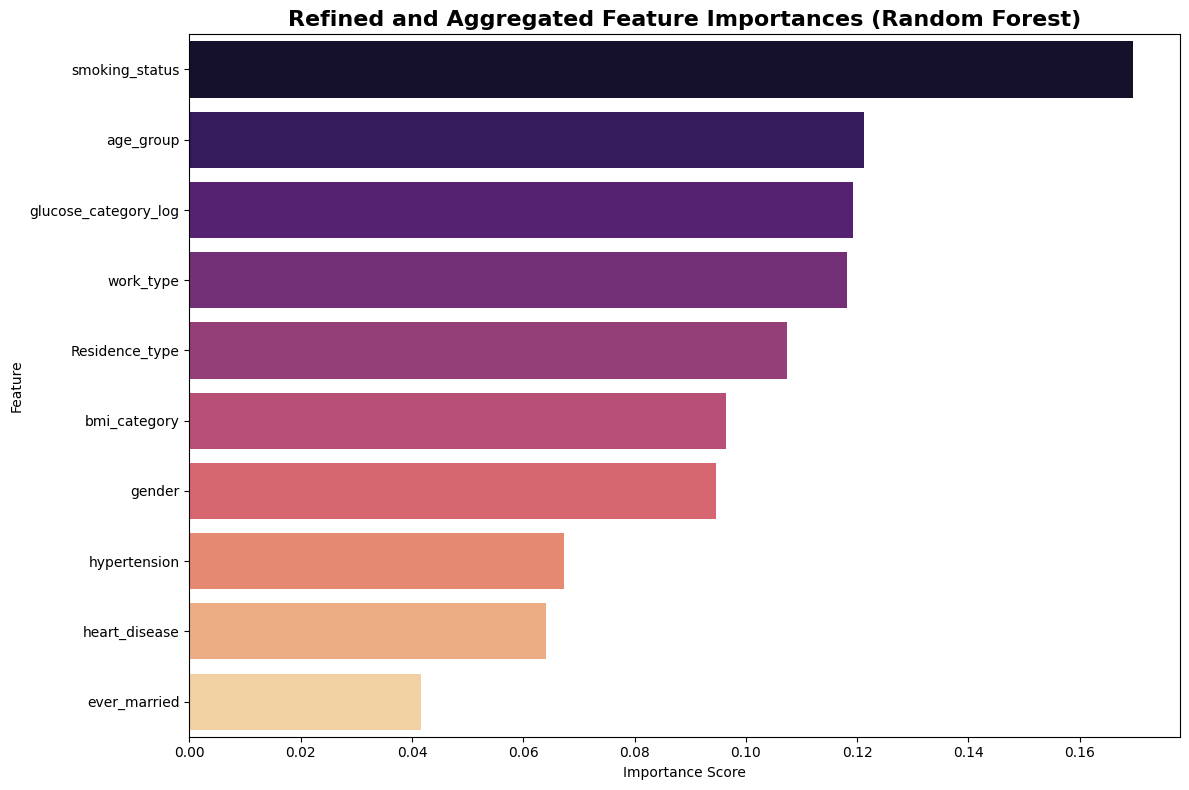

In [ ]:
# --- Step 6: Plot the Aggregated Feature Importances ---
plt.figure(figsize=(12, 8))
sns.barplot(
    x=final_importances_series.values, y=final_importances_series.index, palette="magma"
)
plt.title(
    "Refined and Aggregated Feature Importances (Random Forest)",
    fontsize=16,
    weight="bold",
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()  # Displays the plot without saving

**Interpretation:** The model highlights smoking status as the most important feature for predicting stroke risk, followed closely by age group and glucose category (log). This indicates that these factors contribute most significantly to the model's ability to differentiate between stroke and non-stroke cases.

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------